## Video Classficiation

## Table of Contents
* Overview
* Impage Packages
* Helper Functions
* Load data
* Visualize video data
* Create Training and Validation dataset
* Modeling with Conv3D
* Modeling with EfficientNet
* Conclusion
* References

## Import Packages

In [1]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
print(sys.version)


3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [2]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Configuration

In [3]:
class CFG:
    epochs = 10
    batch_size = 32
    df = pd.read_csv('/kaggle/input/classesucf101/classes.csv')
    classes = list(df[' class_name'][:10])

In [7]:
import pandas as pd

df = pd.read_csv('/kaggle/input/classesucf101/classes.csv')
classes = list(df[' class_name'][:10])

print(classes)


['cartwheel', 'catch', 'clap', 'climb', 'dive', 'draw_sword', 'dribble', 'fencing', 'flic_flac', 'golf']


In [4]:
classes

NameError: name 'classes' is not defined

## Helper Functions

In [4]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images, duration=100):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=duration / 1000)  # Преобразуйте длительность в секунды
    return embed.embed_file('./animation.gif')


## Import dataset
Load videos of selected classes from this dataset.

In [5]:
file_paths = []
targets = []

for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/videosucf101/videos/{cls}/**.avi")
    
    # Исключение последних двух видео
    sub_file_paths = sub_file_paths[:-2]
    
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)


***Узнаем,какие два файла в каждом классе не трогали 

In [12]:
import os
from pathlib import Path

def get_last_two_files(folder_path):
    folder = Path(folder_path)
    
    last_two_files = []
    
    for cls_folder in folder.iterdir():
        if cls_folder.is_dir():
            files = sorted(cls_folder.iterdir(), key=os.path.getmtime)[-2:]
            last_two_files.extend([file.name for file in files])
    
    return last_two_files

# Пример использования
folder_path = "/kaggle/input/videosucf101/videos"
last_two_files = get_last_two_files(folder_path)

print("Названия последних двух файлов в каждой папке:")
print(last_two_files)


Названия последних двух файлов в каждой папке:
['catch_video_10.avi', 'catch_video_33.avi', 'shoot_ball_video_101.avi', 'shoot_ball_video_111.avi', 'clap_video_74.avi', 'clap_video_8.avi', 'pushup_video_52.avi', 'pushup_video_72.avi', 'push_video_106.avi', 'push_video_109.avi', 'fencing_video_68.avi', 'fencing_video_23.avi', 'golf_video_13.avi', 'golf_video_103.avi', 'dive_video_105.avi', 'dive_video_92.avi', 'climb_video_87.avi', 'climb_video_36.avi', 'cartwheel_video_159.avi', 'cartwheel_video_201.avi', 'pullup_video_88.avi', 'pullup_video_37.avi', 'sword_exercise_video_118.avi', 'sword_exercise_video_107.avi', 'jump_video_24.avi', 'jump_video_91.avi', 'pour_video_29.avi', 'pour_video_37.avi', 'dribble_video_37.avi', 'dribble_video_132.avi', 'situp_video_105.avi', 'situp_video_64.avi', 'sit_video_65.avi', 'sit_video_90.avi', 'swing_baseball_video_15.avi', 'swing_baseball_video_86.avi', 'flic_flac_video_9.avi', 'flic_flac_video_87.avi', 'pick_video_101.avi', 'pick_video_3.avi', 'throw

In [13]:
len(targets)

1130

## Visualize video data
I will take 10 frames from a video and resize to image with size (224, 224) and convert to gif file for visulization.

(10, 224, 224, 3)



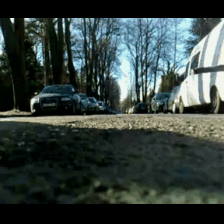

In [14]:
sample_video = frames_from_video_file(file_paths[0], n_frames = 10)
print(sample_video.shape)
to_gif(sample_video, duration=10)



## Create Training and Validation dataset

In [6]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/1130 [00:00<?, ?it/s]

In [7]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.3, random_state=42)
val_features, test_features, val_targets, test_targets = train_test_split(val_features, val_targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape,test_features.shape, len(train_targets), len(val_targets),len(test_targets)

((791, 10, 224, 224, 3),
 (271, 10, 224, 224, 3),
 (68, 10, 224, 224, 3),
 791,
 271,
 68)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [9]:
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
test_ds =  tf.data.Dataset.from_tensor_slices((test_features, test_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [21]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Delete unused data to release memory.

In [11]:
del train_features
del val_features
del test_features
gc.collect()

18

Evaluate the Conv3D Model.

In [12]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


## Modeling with EfficientNet
Now create a Model based on EfficientNet pretrained model.

In [13]:
net = tf.keras.applications.EfficientNetB1(include_top = False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(CFG.classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])



27018416/27018416 [==============================] - 0s 0us/step


Visualize the model.

In [33]:
#tf.keras.utils.plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

Train this model for 10 epochs and save best model.

In [14]:
history = efficient_net_model.fit(
    train_ds,
    epochs = 15,
    validation_data=valid_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5", 
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/15


2023-11-11 18:33:28.674911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 60s 1s/step - loss: 1.9922 - accuracy: 0.4058 - val_loss: 1.6339 - val_accuracy: 0.5572
Epoch 2/15
25/25 [==============================] - 26s 1s/step - loss: 1.3813 - accuracy: 0.6675 - val_loss: 1.2442 - val_accuracy: 0.6605
Epoch 3/15
25/25 [==============================] - 27s 1s/step - loss: 1.0778 - accuracy: 0.7674 - val_loss: 1.0286 - val_accuracy: 0.7491
Epoch 4/15
25/25 [==============================] - 27s 1s/step - loss: 0.9015 - accuracy: 0.8154 - val_loss: 0.8899 - val_accuracy: 0.7970
Epoch 5/15
25/25 [==============================] - 30s 1s/step - loss: 0.7809 - accuracy: 0.8432 - val_loss: 0.7919 - val_accuracy: 0.8081
Epoch 6/15
25/25 [==============================] - 27s 1s/step - loss: 0.6870 - accuracy: 0.8660 - val_loss: 0.7200 - val_accuracy: 0.8192
Epoch 7/15
25/25 [==============================] - 27s 1s/step - loss: 0.6238 - accuracy: 0.8913 - val_loss: 0.6632 - val_accuracy: 0.8266
Epoch 8/15
25/25 [=============

Show Learning curve.

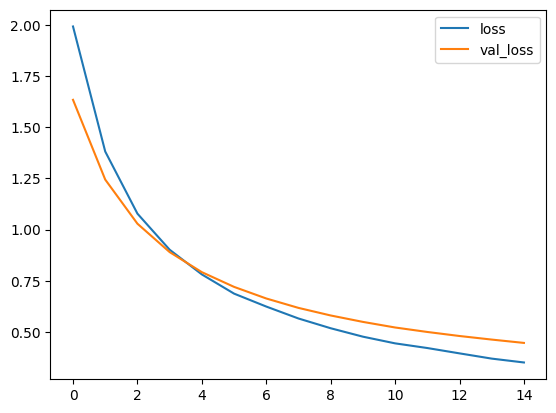

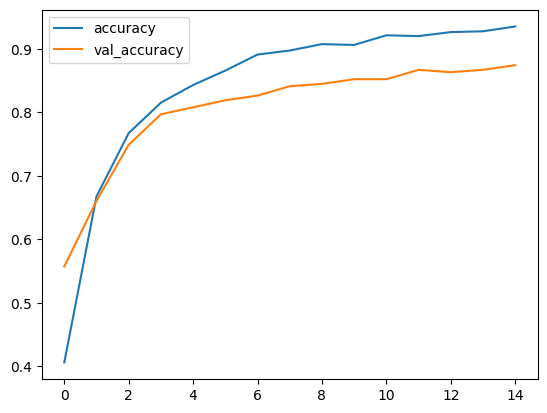

In [15]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

Evaluate the model.

In [16]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

9/9 [==============================] - 6s 698ms/step - loss: 0.4462 - accuracy: 0.8745
Validation Loss:0.44616878032684326 Validation Accuracy:0.8745387196540833


3/3 [==============================] - 2s 429ms/step - loss: 0.3854 - accuracy: 0.8824
Test Loss: 0.3853831887245178
Test Accuracy: 0.8823529481887817


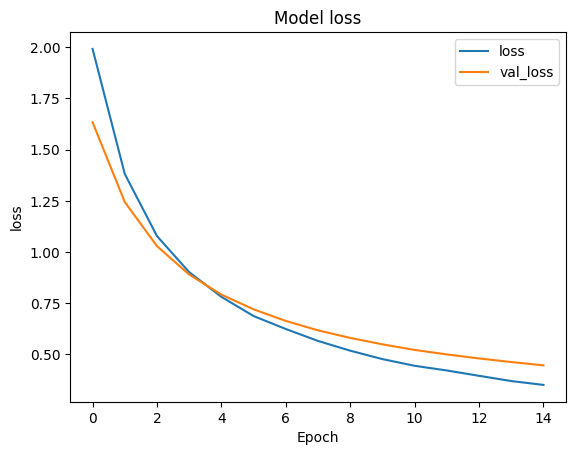

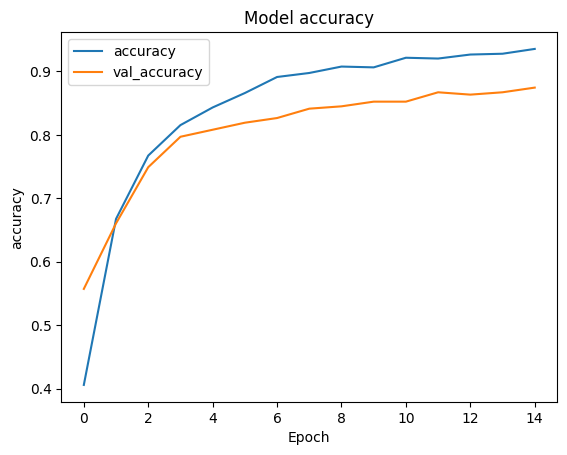

In [19]:
# Оценка модели на тестовом датасете
test_results = efficient_net_model.evaluate(test_ds)

# Вывод результатов тестирования
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


In [20]:
# Сохранение только весов
efficient_net_model.save_weights("efficient_net_weights.h5")

## Conclusions
In this notebook I create 2 kinds of video classification models, one is Conv3D architecture, another is based on pretrained EfficientNet Model as known as Transfer Learning. Transfer Learning can help boost accuracy of video classification model when training sample size is small. That's great. 

## References
* https://www.tensorflow.org/tutorials/load_data/video